In [7]:
#restart the kernel if switching from inline to notebook
import matplotlib.pyplot as plt
%matplotlib notebook 
plt.style.use('seaborn-whitegrid')
import corner

import numpy as np
import numpy.linalg
import scipy.stats
from scipy.signal import argrelextrema
import pandas as pd

import emcee
import george

from subsample import subsample # daniela's code
from emcee_utils import walker_params, plot_gpfit
#from plotting import plot_steps
from plotting import plot_lightcurve, plot_folded_lightcurve, plot_mcmc_sampling_results, plot_steps

In [8]:
txt = "5318.csv"
data = pd.read_csv(txt, delimiter=',')

tsample = data.mjd
fsample = data.magcorrOO
flux_err = data.sigmapsf

In [9]:
data.head()

,Unnamed: 0,objectId,jd,fid,pid,diffmaglim,programid,candid,isdiffpos,tblid,...,exptime,obsdate,mjd,magcorrZTF,magOO,phaseangle,heliodist,geodist,velocity,magcorrOO
0,618257,ZTF18acanzmr,2.458398e+06,1,643478173315,20.7072,1,643478173315015003,t,3,...,30.0,2018-10-06T11:28:34.000,58397.477743,0.0332,18.202296,25.331173,2.285977,1.858844,0.208733,-0.369096
1,656040,ZTF18acbyomy,2.458424e+06,2,669380334015,20.4425,1,669380334015015035,t,35,...,30.0,2018-11-01T09:07:40.996,58423.379907,-0.2224,17.108835,21.461197,2.246522,1.534311,0.041417,-0.131235
2,658941,ZTF18acbzdlm,2.458424e+06,1,669411824015,20.0388,1,669411824015015017,t,17,...,30.0,2018-11-01T09:53:02.000,58423.411400,1.1469,17.629764,21.453295,2.246474,1.533948,0.040351,0.717136
3,703432,ZTF18acecblq,2.458429e+06,1,674338714015,20.7330,1,674338714015015013,t,13,...,30.0,2018-11-06T08:07:45.002,58428.338287,0.3085,17.502880,20.152149,2.238955,1.479159,0.005558,-0.094380
4,713892,ZTF18acclmmm,2.458426e+06,1,671398284015,20.5974,1,671398284015015056,t,56,...,30.0,2018-11-03T09:33:31.997,58425.397859,0.3574,17.579274,20.953106,2.243442,1.511496,0.024840,-0.021874


<IPython.core.display.Javascript object>


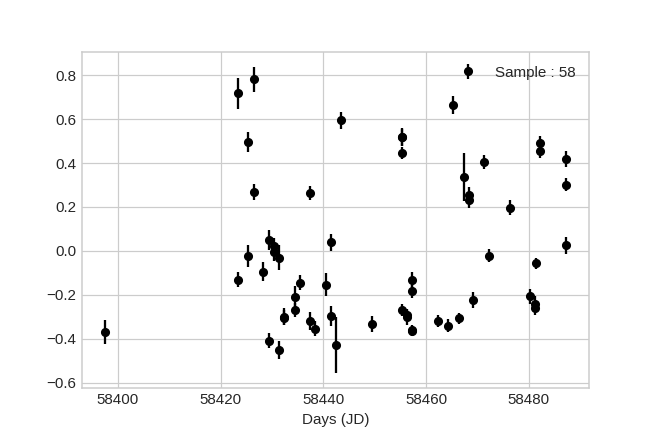

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
#ax.set_title("%i nights, %i data points"%(days, len(fsample)))
ax.set_xlabel("Days (JD)")
ax.errorbar(tsample, fsample, yerr=flux_err, fmt="o", markersize=5,
            color="black", zorder=10, 
            label="Sample : " + str(len(tsample)))
ax.legend()

In [6]:
def prior(params):

    """
    Calculated the log of the prior values, given parameter values.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    param[0] : float
        mean (between 0 and 2)

    param[1] : float
        log amplitude (between -10 and 10)

    param[2] : float
        gamma (log gamma between 0.1 and 40)

    param[3] : float
        log period (period between 1h and 24hrs)

    Returns
    -------
    sum_log_prior : int
        sum of all log priors (-inf if a parameter is out of range)

    """

    p_mean = scipy.stats.norm(1, 0.5).logpdf(params[0])
    #p_log_amp = scipy.stats.uniform(-10,30).logpdf(params[1])
    p_log_amp = scipy.stats.norm(np.log(0.15), np.log(2)).logpdf(params[1])
    p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    ###print this line to get the prob value: p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    #p_period = scipy.stats.uniform(np.log(1./24.), -np.log(1./24.)).logpdf(params[3])
    p_period = scipy.stats.halfcauchy(loc=np.log(0.5/24.), scale=np.exp(2./24.)).logpdf(params[3])

    sum_log_prior =  p_mean + p_log_amp + p_log_gamma + p_period

    if np.isnan(sum_log_prior) == True:
        return -np.inf

    return sum_log_prior

def logl(params, gp, tsample, fsample, flux_err):
    # compute lnlikelihood based on given parameters
    gp.set_parameter_vector(params)

    try:
        gp.compute(tsample, flux_err)
        lnlike = gp.lnlikelihood(fsample)
    except np.linalg.LinAlgError:
        lnlike = -1e25
    return lnlike

def post_lnlikelihood(params, gp, tsample, fsample, flux_err):

    """
    Calculates the posterior likelihood from the log prior and
    log likelihood.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    Returns
    -------
    ln_likelihood : float
        The posterior, unless the posterior is infinite, in which case,
        -1e25 will be returned instead.

    """

    # calculate the log_prior
    log_prior = prior(params)

    # return -inf if parameters are outside the priors
    if np.isneginf(log_prior) == True:
        return -np.inf

    try:
        lnlike = logl(params, gp, tsample, fsample, flux_err)
        ln_likelihood = lnlike+log_prior

    except np.linalg.linalg.LinAlgError:
        ln_likelihood = -1e25

    return ln_likelihood if np.isfinite(ln_likelihood) else -1e25

In [11]:
ndim, nwalkers = 4, 100

In [12]:
# initialize walker parameters
gp_mean = np.mean(fsample)
log_amp = np.log(fsample.max()-fsample.min())
gamma = 1
log_period = np.log(0.5)

params = [np.mean(fsample), log_amp, gamma, log_period]

# set up gp kernel
kernel = np.exp(log_amp) * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
gp = george.GP(kernel, fit_mean=True, mean=gp_mean)
gp.compute(tsample, flux_err)

# equally distributed starting period values
p_start = np.array(params)/100.
cov_matrix = np.sqrt(np.diag(p_start)**2)
p0 = np.random.multivariate_normal(mean=params, cov=cov_matrix, size=(nwalkers))
x = np.log(np.linspace(2,12,nwalkers)/24.)
p0[:,3] = x


In [13]:
threads=1
sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood, args=[gp, tsample, fsample, flux_err], threads=threads)

In [14]:
%%time
mcmc_sampling = sampler.run_mcmc(p0, 100)

/home/christina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log


CPU times: user 35.5 s, sys: 71.6 ms, total: 35.6 s
Wall time: 35.5 s


<IPython.core.display.Javascript object>


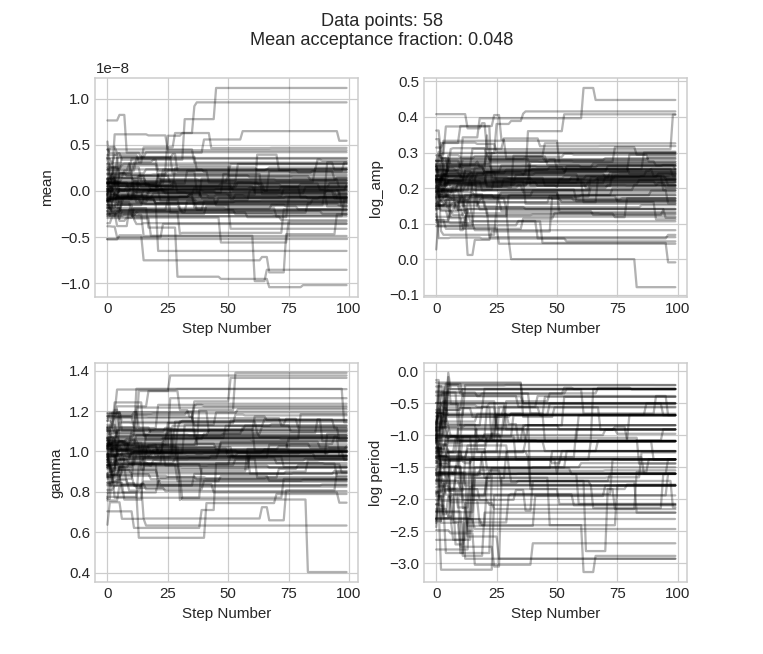

In [15]:
plot_steps(sampler, dims = ['mean', 'log_amp', 'gamma', 'log period'], p0=[params], data_pts=len(fsample))

The distribution of periods ended up looking like this.

<IPython.core.display.Javascript object>


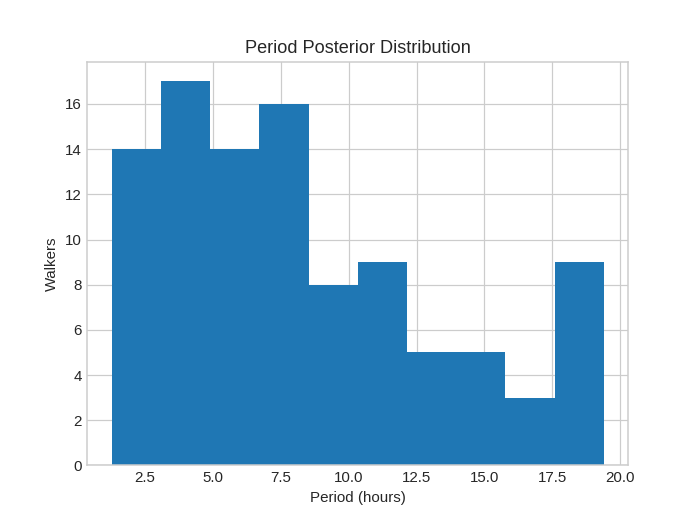

Text(0.5,0,'Period (hours)')

In [16]:
# sampler.chain[chain, step, dimension]
end_period = sampler.chain[:,-1,-1]
end_period.sort()

fig, fx = plt.subplots(1,1)
fx.hist(np.exp(end_period)*24.)
fx.set_title('Period Posterior Distribution')
fx.set_ylabel('Walkers')
fx.set_xlabel('Period (hours)')

In [18]:
periods = np.exp(sampler.chain[:,-1,-1])
best_period = np.median(periods)

<IPython.core.display.Javascript object>


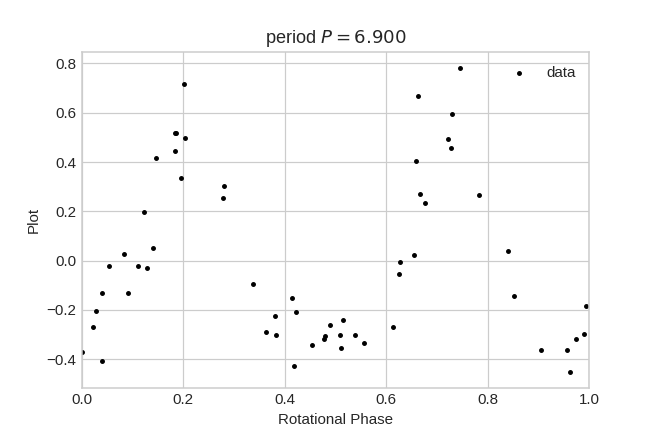

In [19]:
plot_folded_lightcurve(tsample, fsample, best_period)

In [ ]:
def generate_gp(params, fsample, flux_err):

    """
    Sets up the initial parameters for all the walkers using optimized
    parameter values as starting values. The function generates a
    scattered multivatiate gaussian distribution of starting parameter
    values.

    Parameters
    ----------
    params : list
        List of all kernel parameters.

    Returns
    -------
    p0 : numpy.ndarray
        The initial walker parameters [nwalker, ndim]

    gp : george.gp.GP
        GP kernel set with the optimized parameter values.

    """

    gp_mean, log_amp, gamma, log_period = params

    kernel = np.exp(log_amp) * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
    gp = george.GP(kernel, fit_mean=True, mean=gp_mean)
    gp.compute(fsample, flux_err)

    return gp

def plot_steps_from_saved(results, dims=None, data_pts=None):
    fig, ax = plt.subplots(2, 2, figsize=(7,6))
    fig.subplots_adjust(wspace=0.25, hspace=0.3)

    fig.suptitle("Data points: " + str(data_pts))

    axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

    iterations = np.arange(results.shape[1])

    for i in range(results.shape[2]):
        axs[i].set_xlabel('Step Number')
        axs[i].set_ylabel('{}'.format(dims[i]))

        for j in range(results.shape[0]):
            param = results[j,:,i]
            axs[i].plot(iterations, param, 'k-', alpha=0.3)

    return axs

results = sampler.chain
nmodels = 10
npred = 1000
namestr = '5318'
true_period = None

results_flat = results.reshape(results.shape[0]*results.shape[1],results.shape[2])

idx = np.random.choice(np.arange(0, results.shape[0] ,1, dtype=int), size=nmodels)
print(idx)

t_pred = np.linspace(tsample[0], tsample.iloc[-1], npred)
m_all = np.zeros((nmodels, t_pred.shape[0]))


params = [np.mean(fsample), (np.log(fsample.max()-fsample.min())), 1, np.mean(results.T[3])]

gp = generate_gp(params, fsample, flux_err)


# loop through the indices of samples, for each sample from the GP
# conditional on the data points
for i,j in enumerate(idx):
    #only selects from the last step in the chain
    p = results[j, results.shape[1]-1]
    print(p)
    pnew = [p[0], p[1], p[2], p[3]]

    gp.set_parameter_vector(pnew)
    mean_model = gp.sample_conditional(fsample, t_pred)
    m_all[i] = mean_model

print("m_all : " +str(m_all[:2]))
x = np.random.choice(idx)

guess_period = np.exp(results[x,results.shape[1]-1][3])
print(x)


fig, ax = plt.subplots(1, 1, figsize=(6,4))

plot_lightcurve(tsample, fsample,
                    models=(t_pred, m_all), ax=ax)

plt.tight_layout()
plt.savefig(namestr + "_lc.pdf", format="pdf")

# plot folded light curve
fig, ax = plt.subplots(1, 1, figsize=(6,4))


if true_period:
    ax = plot_folded_lightcurve(tsample, fsample, guess_period, flux_err=0.01,
                      models=[t_pred, m_all[:2]],
                      true_lightcurve=true_lightcurve, ax=ax, use_radians=False)
else:
    ax = plot_folded_lightcurve(tsample, fsample, guess_period, flux_err=flux_err,
                      models=[t_pred, m_all[:2]],
                      ax=ax, use_radians=False)

plt.tight_layout()
plt.savefig(namestr + "_folded_lc.pdf", format="pdf")


# plot histogram of periods
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(np.exp(results_flat[:,-1])*24, bins=100, density=True,
            label="posterior PDF", color="black", alpha=0.5)

if true_period is not None:
    ylim = ax.get_ylim()
    ax.vlines(true_period, 0, ylim[-1], lw=1, color="red", linestyle="dashed", label="true period : " + str(true_period))

ax.set_xlabel("Period in hours")
ax.set_ylabel("Probability")
ax.legend()

plt.tight_layout()
plt.savefig(namestr + "_period_pdf.pdf", format="pdf")

#convert period values from log days to hours
results_hours = np.array(results.reshape(results.shape[0]*results.shape[1],results.shape[2]))
results_hours.T[3] = np.exp(results_hours.T[3])*24.

labels = list(gp.parameter_names)
labels[3] = 'period hours'

# make a corner plot
corner.corner(results_hours[int(-len(results_flat)*0.1):], labels=labels)

# save to file
plt.savefig(namestr + "_corner.pdf", format="pdf")

#plot trace plot
ax = plot_steps_from_saved(results_hours.reshape(results.shape[0],results.shape[1],results.shape[2]), 
                           dims = ['mean', 'log_amp', 'gamma', 'period'], data_pts=len(fsample))
plt.savefig(namestr + "_trace.pdf", format="pdf")


We can now see how the different posterior distributions model the original sampled data. Feel free to give the file names **namestr** an appropriate title.

In [ ]:
def save_chain(file_name, sampler):
        header = str(sampler.chain.shape)
        np.savetxt(file_name, sampler.flatchain, header=header)
        return

filename = "5318"

save_chain(filename + "_results.txt", sampler)

#plot_mcmc_sampling_results(np.array(tsample), fsample, flux_err, gp, sampler, namestr=filename + "_plots")

Hopefully, most of the walkers will have converged onto the correct period. Typically, the longer you run it, the more likely all the walkers will settle onto the correct value. 

In [1]:
np.exp(-5)

NameError: name 'np' is not defined

In [ ]:
# resample from weights
new_samples = sampler.flatchain
print(new_samples)

In [ ]:
labels = list(gp.parameter_names)
print(labels)
type(labels)
#labels
labels[3] = 'period hours'
print(labels[3])
corner.corner(new_samples[int(-len(new_samples)*0.1):], labels=labels)

## Presentation Graphs : AAS 233 and DPS 50

In [ ]:
# you can set the delay to look at different parts of the lightcurve
days, delay = 1, 0


# convert days to points
span = 2880 * days
start_pt = 2880 * delay

time = np.array(data.time[start_pt:span+start_pt])
flux = np.array(data.flux[start_pt:span+start_pt])

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(time, flux, '-', alpha=1, 
        label="Original : " + str(round(true_log_p[asteroid], 5)))
ax.set_xlabel("Time", fontsize=25)
ax.set_ylabel("Brightness", fontsize=25)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlim([time[0], time[-1]])

In [ ]:
days, delay = 5, 0

# convert days to points
span = 2880 * days
start_pt = 2880 * delay

time = np.array(data.time[start_pt:span+start_pt])
flux = np.array(data.flux[start_pt:span+start_pt])

flux_err = np.ones_like(flux) * np.std(flux)/10.0
tsample, fsample, flux_err = subsample(time, flux, flux_err=flux_err, npoints=20, kind="telescope")

fig, ax = plt.subplots(1,1, figsize=(9,6))
#ax.set_title("%i nights, %i data points"%(days, len(fsample)))
ax.set_xlabel("Days (JD)")
ax.errorbar(tsample, fsample, yerr=flux_err, fmt="o", markersize=5,
            color="black", zorder=10)#, 
            #label="Sample : " + str(len(tsample)))

ax.plot(time, flux, '-', alpha=0.3)#, 
        #label="Original : " + str(round(true_log_p[asteroid], 5)))
ax.set_xlabel("Time", fontsize=25)
ax.set_ylabel("Brightness", fontsize=25)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlim([time[0], time[-1]])
#ax.legend()

<IPython.core.display.Javascript object>


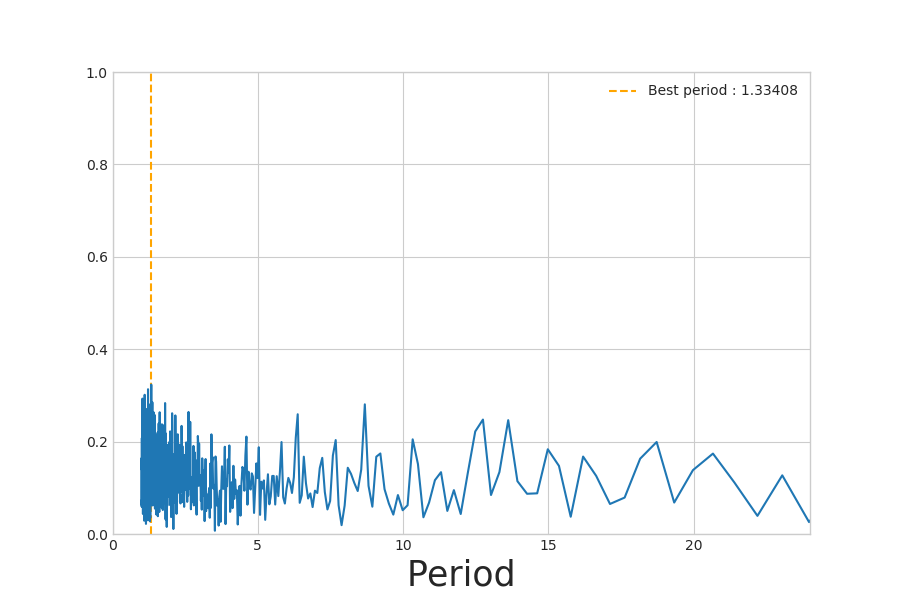

In [26]:
fig, cx = plt.subplots(1,1, figsize=(9,6))
cx.plot((1./freq)*24.,power)
cx.set_xlabel('Period', fontsize=25)
cx.vlines(best_period*24., 0, 1, colors='orange', linestyles='--', 
          label = 'Best period : ' + str(round(1./best_freq*24., 5)))
cx.set_xlim([0,24])
cx.set_ylim([0,1])
cx.legend()

In [25]:
# resample from weights
new_samples = sampler.flatchain

# plot some light curves with example models

# first, get the total number of available samples
nsamples = new_samples.shape[0]

# plot histogram of periods
fig, ax = plt.subplots(1, 1, figsize=(9,6))
ax.hist((sampler.chain[:,-1,-1]), bins=100, density=True,
            label="posterior PDF", color="black", alpha=0.5)

#if true_period is not None:


ax.set_xlabel("Period in hours", fontsize=25)
ax.set_ylabel("Probability", fontsize=25)


ylim = ax.get_ylim()
print(true_p[asteroid])
ax.vlines(true_p[asteroid]*24, 0, ylim[1], lw=1, color="blue", 
          linestyle="dashed", label="true period : " + str(true_p[asteroid]*24))

ax.vlines(best_period*24., 0, ylim[1], lw=1, color="red", 
          linestyle="dashed", label="l-s period : " + str(round(best_period*24.,5)))
ax.set_xlim([0,24])
ax.set_yticklabels([])

plt.tight_layout()

ax.legend()
#plt.savefig(namestr + "_period_pdf.pdf", format="pdf")

<IPython.core.display.Javascript object>

NameError: name 'true_p' is not defined